#*FORECASTING* CON REDES LSTM - PARTE 7: ANÁLISIS DE LA IMPORTANCIA DE LAS CARACTERÍSTICAS (*FEATURE IMPORTANCES*)

## Contenido

1. [Introducción](#scrollTo=wHQ1yXwrk6CN)
2. [El set de datos](#scrollTo=QDm0J6L-7rGI&line=1&uniqifier=1)
3. [El problema a resolver](#scrollTo=CBJV_YRvj5CZ&line=1&uniqifier=1)
4. [Lectura del set de datos](#scrollTo=Es6L4nEckb3S&line=1&uniqifier=1)
5. [Análisis detallado de la variable tiempo](#scrollTo=6XaUeEUsM0Gf)
5. [*Feature engineering*](#scrollTo=Ex5fnN-tMD7c&line=25&uniqifier=1)
6. [Pre-procesamiento](#scrollTo=vd5lyqNrlfFg)
7. [Creación y entrenamiento del modelo](#scrollTo=016D9eVw3Beb)
8. [Desempeño del modelo](#scrollTo=ZkI9vr5S69i_)
9. [Predicciones con el modelo entrenado](#scrollTo=fvqk4f8L3aXE&line=1&uniqifier=1)
10. 🔥🔥[Análisis de la importancia de las características (*feature importances*)](#scrollTo=_7Ps-fqE0x0t)🔥🔥
11. [Conclusiones y sugerencias](#scrollTo=0AFY2trj_KLo&line=1&uniqifier=1)

## 1. Introducción

En el video anterior vimos cómo implementar una Red LSTM con múltiples variables de entrada y múltiples instantes de tiempo de salida, e incluimos la codificación de las variables temporales.

En este tutorial veremos cómo tomar el modelo obtenido para analizar la importancia que tienen las diferentes variables (características) usadas a la entrada al momento de generar la partición.

Así que no modificaremos ningún elemento del código desarrollado en el tutorial anterior y simplemente nos enfocaremos en usar el modelo entrenado para analizar la importancia de las características.

##2. El set de datos

Recordemos que estamos usando el  [weather dataset](https://www.bgc-jena.mpg.de/wetter/weather_data.html), un set de datos que contiene el registro histórico de 14 diferentes variables climáticas en el período entre 2009 y 2015.

En el segundo video de la serie realizamos el análisis exploratorio del dataset y realizamos este pre-procesamiento:

1. Hicimos el manejo de datos faltantes
2. Verificamos que el dataset no tuviese valores extremos
3. Re-interpolamos el dataset para garantizar una periodicidad de 1 hora

Este será el set de datos que usaremos en este tutorial.

##3. El problema a resolver

Crear y entrenar una Red LSTM usando el enfoque multivariado + uni-step + variables temporales y **al final del entrenamiento analizar la importancia de las variables**:

![](https://drive.google.com/uc?export=view&id=1Gmd9rVq3oQw7JJA0RgIzBdcZC0ahrzCA)

En este caso tomaremos como entrada al modelo 13 covariables (las mismas usadas en el video anterior) **junto con las variables temporales** y a la salida intentaremos predecir 4 horas de temperatura a futuro (de ahí el término multi-step).

Específicamente, con respecto al video anterior (multivariado-multistep) tendremos que modificar en nuestro código:

1. **Codificación de las variables temporales**
2. **El pre-procesamiento** para que no se realice el escalamiento de las variables temporales
2. **La Red LSTM**, para que sea entrenada incluyendo las variables temporales

##4. Lectura del set de datos

Recordemos que usaremos el dataset implementado en el [segundo video de la serie](https://youtu.be/R8MEPGn9sFI), sobre el cual ya hemos hecho un pre-procesamiento previo:

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Montar Google Drive
drive.mount('/gdrive')

# Leer set de datos
ruta = '/gdrive/MyDrive/02-CODIFICANDOBITS.COM/05-YouTube/02-Videos/2023-05-05-LSTMSeriesTiempo-Univariate-Multistep/release/data/'
df = pd.read_csv(ruta+'weather_dataset_preprocesado.csv', index_col='datetime', parse_dates=['datetime'])
df

Mounted at /gdrive


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
datetime,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-24 12:00:00,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,2.92,4.00,174.1
2014-09-24 13:00:00,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,1.57,2.48,173.0
2014-09-24 14:00:00,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,2.79,4.75,202.5


## 5. Análisis detallado de la variable tiempo

### 5.1. Características básicas

Veamos algunas características básicas del índice de nuestra serie (el cual contiene, precisamente, la variable tiempo):

In [2]:
# Va del 1 de enero de 2009 al 24 de septiembre de 2014
# Es decir casi 6 años
print(df.index[0])
print(df.index[-1])
print(df.index[-1]-df.index[0])

2009-01-01 01:00:00
2014-09-24 16:00:00
2092 days 15:00:00


In [3]:
# La serie tiene frecuencia horaria: por cada hora tenemos un registro
# o muestra
pd.infer_freq(df.index)

'H'

Y vemos que cada marca temporal tiene los datos de año, mes, día y hora.

La idea es presentar esta información al modelo pero antes de determinar cómo hacerlo tenemos qué encontrar cuáles de estas variables (año, mes, día, hora) son relevantes para predecir la temperatura.

### 5.2. ¿Qué elementos de la variable temporal resultan relevantes?

Podríamos presentar al modelo toda la información incluida en cada marca de tiempo (año, mes, día, hora) pero esto podría afectar el entrenamiento pues tendríamos muchas variables y no necesariamente todas son relevantes.

La pregunta es entonces, ¿cómo sabemos cuáles de estas variables temporales son relevantes al momento de predecir la temperatura?

Una manera de lograr esto es usando la [Transformada de Fourier](https://youtu.be/h4PTucW3Rm0?si=UxDr_kaKP6IAh-jj), una herramienta matemática que nos permite conocer los **componentes en frecuencia de una señal**.

Los componentes en frecuencia son aquellos elementos de la señal que se repiten con una cierta periodicidad (cada cierto tiempo) y eso es lo que nos interesa encontrar en nuestra señal.

Entendamos la idea de la Transformada de Fourier con un ejemplo:

> Creemos una señal cosenoidal, con una frecuencia de 100 Hz (es decir que tiene 100 ciclos en 1 segundo) y veamos su espectro en frecuencia calculado con la Transformada de Fourier.

Comencemos creando la señal y dibujándola con respecto al tiempo:

In [4]:
import plotly.express as px
import numpy as np

# Crear la señal
N = 2000                # Número total de muestras (datos): [muestras]
muestras_seg = 4000   # Cantidad de muestras en 1 segundo: [muestras/s]
t = np.linspace(0.0, N/muestras_seg, N ) # Tiempo: desde 0 hasta N/muestras_per_seg = 0.83 s
y = np.cos(100.0 * 2.0*np.pi*t)

# Graficarla con respecto al tiempo
fig = px.line(x=t[0:100], y=y[0:100])
fig.update_layout(xaxis_title='Tiempo (s)')
fig.show()

Vemos que la señal:

- Tiene un periodo de 0.01 segundos
- Lo que equivale a una frecuencia de 1/0.01 Hz = 100 Hz

La idea ahora es llegar a esta misma conclusión pero usando la Transformada de Fourier:

In [5]:
# 1. Calcular la magnitud de la Transformada de Fourier derecha
tf = np.abs(np.fft.rfft(y,N))

# 2. Calcular vector frecuencias (eje horizontal)
frecs = np.fft.rfftfreq(N, d=1./muestras_seg)

# 3. Graficar
fig = px.line(x=frecs, y=tf)
fig.update_layout(xaxis_title=f'Frecuencia (1/s, Hz)')
fig.show()

Y vemos que:

- En la gráfica hay un pico exactamente a una frecuencia de 100 Hz
- Lo que equivale a un periodo de 1/100 = 0.01 s

La gráfica anterior es lo que se conoce como el **espectro en frecuencia de la señal**.

Y podemos seguir la misma lógica anterior para ver el espectro en frecuencia de la Temperatura.

Comencemos extrayendo esta variable y viendo su comportamiento en el tiempo:

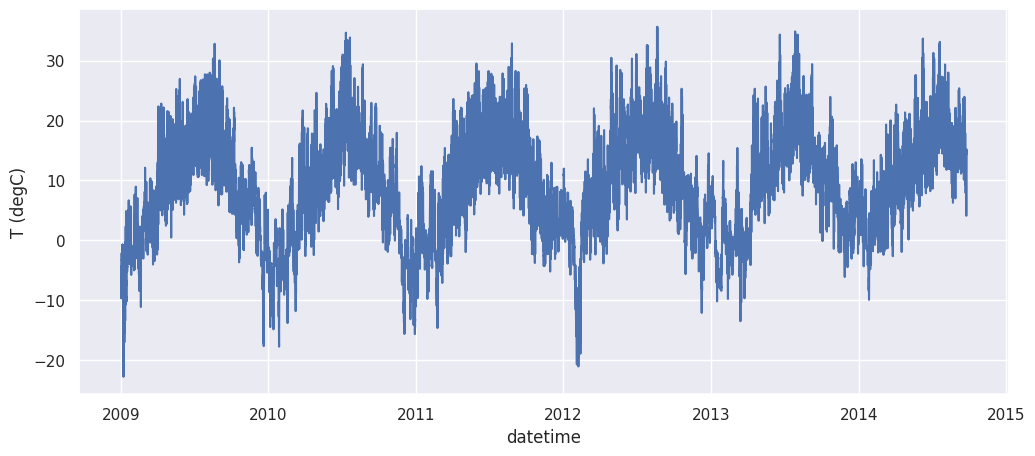

In [6]:
# Importar seaborn
import seaborn as sns
sns.set()

# Extraer la temperatura
temp = df['T (degC)']

# Y graficarla
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(temp, ax=ax);

Y vemos que efectivamente hay algo de periodicidad en esta Serie de Tiempo.

Pero no resulta fácil si está asociada con el año, con el mes, con el día o con la hora. Así que podemos usar la Transformada de Fourier para ver esto más claramente:

In [7]:
# 0. Parámetros de la serie de tiempo
N = len(df['T (degC)'])      # Cantidad de muestras: [muestras]
muestras_hora = 1            # Número de muestras/horas: [muestras/h]

# 1. Calcular la magnitud de la Transformada de Fourier derecha
tf = np.abs(np.fft.rfft(df['T (degC)'],N))

# 2. Calcular vector frecuencias (eje horizontal)
frecs = np.fft.rfftfreq(N, d=1./muestras_hora)

# 3. Graficar
# Como tenemos 1 muestra por hora pero la serie dura varios años
# usaremos una escala logarítmica en el eje horizontal
fig = px.line(x=frecs, y=tf, log_x=True)
fig.update_layout(xaxis_title=f'Frecuencia (1/H)')
fig.show()

Y en el espectro en frecuencia de nuestra Serie de Tiempo vemos dos componentes predominantes, ubicados en las frecuencias:

1. $119.4648e^{-6}$ [1/H]
2. $0.0416733$ [1/H]

Pero no nos interesa saber la frecuencia sino el equivalente en horas, días, semanas, años, etc.

Para hallar esta equivalencia simplemente calculamos el valor inverso (para pasar de frecuencia a tiempo):

In [8]:
frec1 = 119.4648e-6
frec2 = 0.0416733

print(f'La frecuencia {frec1} equivale a {1/frec1} horas')
print(f'La frecuencia {frec2} equivale a {1/frec2} horas')

La frecuencia 0.0001194648 equivale a 8370.66650594987 horas
La frecuencia 0.0416733 equivale a 23.996179808174535 horas


Vemos que la segunda frecuencia equivale prácticamente a 24 horas, es decir 1 día.

Por otra parte, la primera frecuencia equivale a 8370.66 horas. Hagamos la conversión a años teniendo en cuenta que:

- 1 año tiene **en promedio** 365.25 días (para incluir años bisiestos)
- 1 día tiene 24 horas

Así que, 8370.6665 horas equivalen a:

$8370.6665 \text{ horas} x \frac{1 \text{ día}}{24 \text{ horas}} x \frac{1 \text{ año}}{365.25 \text{ días}}$:

In [9]:
resultado = (1/frec1)*(1/24)*(1/365.25)
print(f'La frecuencia {frec1} equivale a {resultado} años')

La frecuencia 0.0001194648 equivale a 0.9549014950889653 años


¡Es decir prácticamente un año!

En resumen, este análisis nos permite concluir que:

> Las variables día y año son relevantes para nuestra Serie de Tiempo.

Y con esto nos podemos enfocar en la manera de codificarlas.

###5.3. ¿Cómo codificar el año y el día?

Requisitos que debe cumplir la codificación:

1. Debe tener en cuenta el comportamiento cíclico/periódico de la señal a predecir
2. Debe haber continuidad en la representación numérica que usemos para el año y el día

Si codificamos año/día simplemente con los valores originales (2009, 2010, 2011, etc.; 1, 2, 3, ..., 29, 30, etc.) tendremos estos inconvenientes:

1. La representación numérica original no tiene un comportamiento cíclico (ni para los años ni para los días)
2. La representación numérica original contiene saltos (no es continua), especialmente para los días

![](https://drive.google.com/uc?export=view&id=1Got62TEuJKcLHtNKKOBiAft0xfwiJe7K)

Esta representación dificulta al modelo LSTM encontrar patrones que relacionen las variables temporales con la temperatura.

Una solución usada comúnmente en estos casos es **representar las variables temporales con senos y cosenos**, con esto:

1. Se añade a la variable temporal un comportamiento cíclico
2. No habrá saltos

Por ejemplo, codifiquemos los días usando una función coseno:

In [10]:
# Codificar cada combinación AAAA-MM-DD HH:MM:SS a su representación
# en segundos
tiempo_s = df.index.map(pd.Timestamp.timestamp)
tiempo_s

Float64Index([1230771600.0, 1230775200.0, 1230778800.0, 1230782400.0,
              1230786000.0, 1230789600.0, 1230793200.0, 1230796800.0,
              1230800400.0, 1230804000.0,
              ...
              1411542000.0, 1411545600.0, 1411549200.0, 1411552800.0,
              1411556400.0, 1411560000.0, 1411563600.0, 1411567200.0,
              1411570800.0, 1411574400.0],
             dtype='float64', name='datetime', length=50224)

In [11]:
# Por ejemplo, entre dos instantes de tiempos consecutivos
# habrá exactamente 3.600 segundos = 1 hora!
tiempo_s[2]-tiempo_s[1]

3600.0

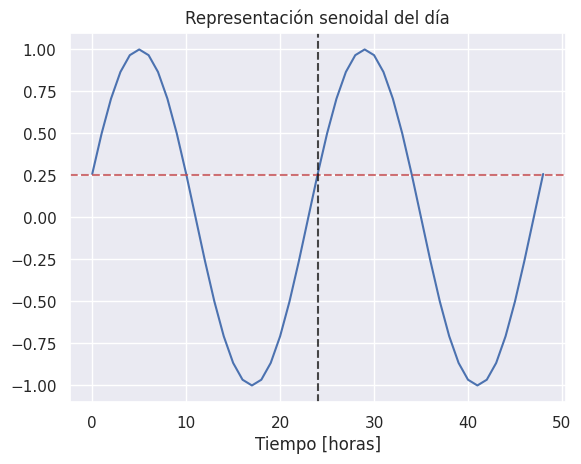

In [12]:
# Definir 1 día en segundos como 24 horas x 60 min x 60 s
dia = 24*60*60

# Representar el día senoidal y cosenoidalmente
# La frecuencia de la función será 1/día
dia_sin = np.sin(tiempo_s * (2 * np.pi / dia))

# Graficar 2 días (48 horas)
fig, ax = plt.subplots()
plt.plot(np.array(dia_sin)[:49])
plt.xlabel('Tiempo [horas]')
plt.title('Representación senoidal del día')

# Dibujar línea horizontal en y = 0.5
ax.axhline(0.25, color='r', linestyle='--', alpha=0.8)

# Dibujar línea vertical en 24 horas
ax.axvline(24, color='k', linestyle='--', alpha=0.8);

Vemos que:

1. No hay saltos
2. Hay periodicidad: la hora 0 equivale a la hora 24, la hora 1 a la hora 25, etc.
3. 👎👎 Varias horas son codificadas con el mismo valor. Ejemplo: 0h, 10h, 24h son codificadas con 0.25 👎👎

Para resolver el problema anterior se puede usar tanto representación senoidal como cosenoidal:

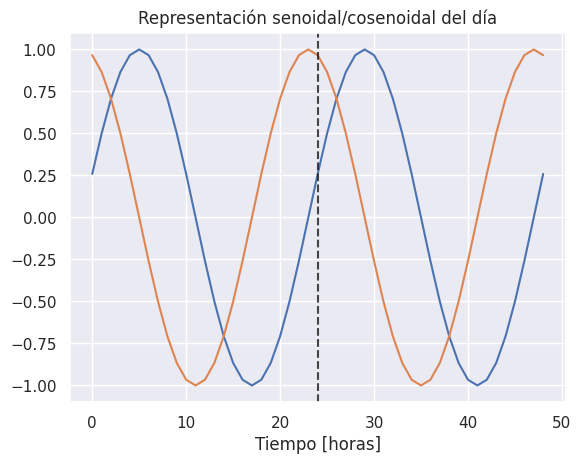

In [13]:
# Representar la hora con senos y cosenos
dia_sin = np.sin(tiempo_s * (2 * np.pi / dia))
dia_cos = np.cos(tiempo_s * (2 * np.pi / dia))

# Graficar 2 días (48 horas)
fig, ax = plt.subplots()
plt.plot(np.array(dia_sin)[:49])
plt.plot(np.array(dia_cos)[:49])
plt.xlabel('Tiempo [horas]')
plt.title('Representación senoidal/cosenoidal del día')

# Dibujar línea vertical en 24 horas
ax.axvline(24, color='k', linestyle='--', alpha=0.8);

Así:

> Con la codificación senoidal y cosenoidal cada instante de tiempo es codificado con un valor único.

Teniendo esto claro, ahora sí podemos codificar las variables temporales (año y día) usando senos y cosenos.

Almacenaremos estas codificaciones en nuevas columnas: `dia_sin`, `dia_cos`, `year_sin`, `year_cos`.

Es importante observar que:

> No es necesario combinar días (seno y coseno) y años (seno y coseno) en una misma variable. Durante el entrenamiento el modelo LSTM aprenderá a ponderarlas de la manera más adecuada.

Este sería el código requerido:

In [14]:
year = (365.2425)*dia # Valor de un año en segundos

df['dia_sin'] = np.sin(tiempo_s * (2 * np.pi / dia))
df['dia_cos'] = np.cos(tiempo_s * (2 * np.pi / dia))
df['year_sin'] = np.sin(tiempo_s * (2 * np.pi / year))
df['year_cos'] = np.cos(tiempo_s * (2 * np.pi / year))
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),dia_sin,dia_cos,year_sin,year_cos
datetime,,,,,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7,2.588190e-01,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3,5.000000e-01,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2,7.071068e-01,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0,8.660254e-01,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0,9.659258e-01,0.258819,0.012916,0.999917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-24 12:00:00,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,2.92,4.00,174.1,7.444113e-12,-1.000000,-0.992546,-0.121868
2014-09-24 13:00:00,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,1.57,2.48,173.0,-2.588190e-01,-0.965926,-0.992633,-0.121157
2014-09-24 14:00:00,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,2.79,4.75,202.5,-5.000000e-01,-0.866025,-0.992720,-0.120445


Tengamos en cuenta que **NO será necesario escalar las 4 variables que acabamos de crear, pues ya están en el rango de -1 a 1**.

Para simplificar el *DataFrame* podemos quitar el índice con las marcas temporales, pues ya están codificadas (esto es opcional):

In [15]:
df = df.reset_index()
df = df.drop(columns=['datetime'])
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),dia_sin,dia_cos,year_sin,year_cos
0,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7,2.588190e-01,0.965926,0.010049,0.999950
1,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3,5.000000e-01,0.866025,0.010766,0.999942
2,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2,7.071068e-01,0.707107,0.011483,0.999934
3,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0,8.660254e-01,0.500000,0.012199,0.999926
4,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0,9.659258e-01,0.258819,0.012916,0.999917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50219,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,2.92,4.00,174.1,7.444113e-12,-1.000000,-0.992546,-0.121868
50220,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,1.57,2.48,173.0,-2.588190e-01,-0.965926,-0.992633,-0.121157
50221,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,2.79,4.75,202.5,-5.000000e-01,-0.866025,-0.992720,-0.120445
50222,984.76,15.20,289.63,6.96,57.79,17.30,10.00,7.30,6.34,10.15,1185.10,2.86,4.32,172.0,-7.071068e-01,-0.707107,-0.992806,-0.119734


## 6. *Feature engineering*

Realizaremos la misma *ingeniería de características del video anterior*:

- A partir de la velocidad y dirección del viento (columnas `wv (m/s)` y `wd (deg)`) calcularemos 2 nuevas características: los componentes del vector viento (nuevas columnas `Wx` y `Wy`)
- Eliminaremos la columna `max. wv (m/s)` (velocidad del viento máxima (en m/s))

![](https://drive.google.com/uc?export=view&id=1SYGFg_Ugmt4oxlxm9mJTKtuxYHBSmP4w)

donde:

- $W_x = wv \cdot cos(wd)$
- $W_y = wv \cdot sin(wd)$

Así que, al igual que en el video anterior, tendremos 13 covariables de entrada al modelo:

In [16]:
# Feature engineering
w_dir = df['wd (deg)']*np.pi/180
Wx = df['wv (m/s)']*np.cos(w_dir)
Wy = df['wv (m/s)']*np.sin(w_dir)

# Eliminar columnas irrelevantes
df.pop('wd (deg)')
df.pop('wv (m/s)')
df.pop('max. wv (m/s)')

# E incluir las columnas de interés
df['Wx'] = Wx
df['Wy'] = Wy
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),dia_sin,dia_cos,year_sin,year_cos,Wx,Wy
0,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,2.588190e-01,0.965926,0.010049,0.999950,-0.204862,-0.046168
1,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,5.000000e-01,0.866025,0.010766,0.999942,-0.245971,-0.044701
2,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,7.071068e-01,0.707107,0.011483,0.999934,-0.175527,0.039879
3,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,8.660254e-01,0.500000,0.012199,0.999926,-0.050000,-0.086603
4,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,9.659258e-01,0.258819,0.012916,0.999917,-0.368202,0.156292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50219,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,7.444113e-12,-1.000000,-0.992546,-0.121868,-2.904532,0.300154
50220,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,-2.588190e-01,-0.965926,-0.992633,-0.121157,-1.558297,0.191335
50221,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,-5.000000e-01,-0.866025,-0.992720,-0.120445,-2.577624,-1.067687
50222,984.76,15.20,289.63,6.96,57.79,17.30,10.00,7.30,6.34,10.15,1185.10,-7.071068e-01,-0.707107,-0.992806,-0.119734,-2.832167,0.398035


##7. Pre-procesamiento

Implica:

1. Partición en train/val/test (80%, 10%, 10%).
2. Generación del dataset supervisado: entrada y salida del modelo
3. Escalamiento **SIN INCLUIR LAS VARIABLES TEMPORALES**

En cada una de estas fases usaremos prácticamente el mismo código usado en los modelos univariados pero con algunas ligeras modificaciones.

### 7.1. Partición del set en entrenamiento, validación y prueba

Esta fase es idéntica a la implementada en el modelo anterior (multivariado - unistep).

A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo **se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos**.

Recordemos además que:
- El set de entrenamiento (*train*) se usará para encontrar los parámetros del modelo
- El set de validación (*val*) para verificar que no haya *under/over-fitting* del modelo y para ajustar sus hiperparámetros
- El set de prueba (*test*) para poner a prueba el mejor modelo encontrado durante el entrenamiento/validación

En este caso usaremos la misma función implementada para los modelos univariados con la diferencia de que en lugar de introducir una *serie* de Pandas, introduciremos el *DataFrame* completo.

Por tanto, la función retornará tres *dataframes* (train, val y test):

In [17]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (40179, 17)
Tamaño set de validación: (5022, 17)
Tamaño set de prueba: (5023, 17)


Observemos que en lugar de una columna cada subset tiene ahora 17 (correspondientes a las covariables).

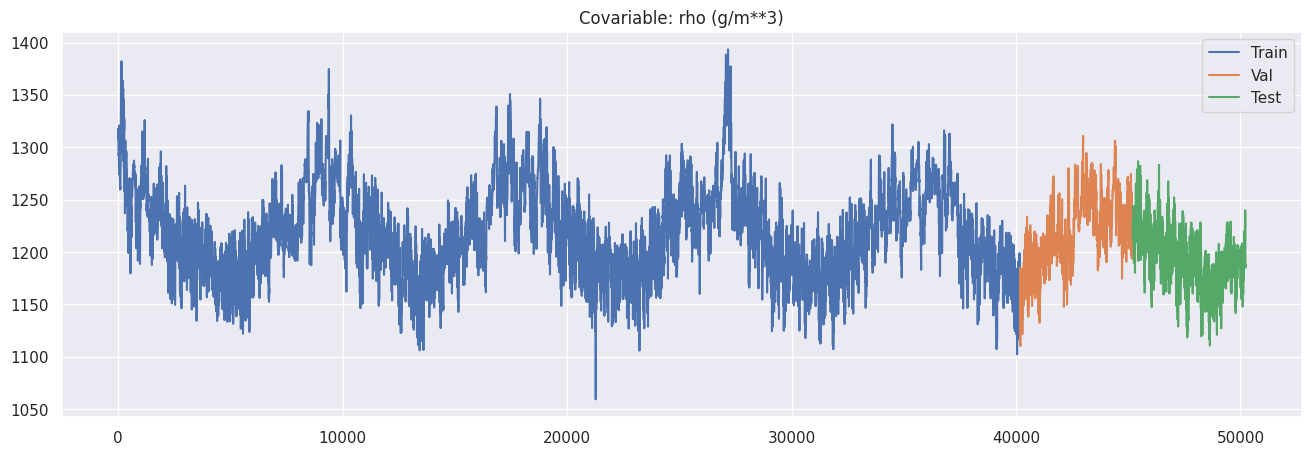

In [18]:
covar = 10 # Índice de la covariable (columna del dataset) a graficar
col = df.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

###7.2 Generación del dataset supervisado (entrada y salida del modelo)

En este caso lo único que cambia con respecto al tutorial anterior es que ahora tendremos 17 *features* de entrada al modelo: las 13 originales + 4 variables temporales.

Debemos ajustar nuestro set de datos de acuerdo a lo especificado en la [documentación de las Redes LSTM en TensorFlow/Keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM):

![](https://drive.google.com/uc?export=view&id=1GnrHTdwbIRqjxm0xpkwWetCrTs_MMEqq)

Así que en este caso cada dato de entrenamiento será:

- Un arreglo de 24 (horas) x 17 (features) correspondiente a la entrada
- Un arreglo de 4 (horas) x 1 (feature):

![](https://drive.google.com/uc?export=view&id=1GoZ9hpf9q9Q-tFUi6kYtBMcWXjcJyNGv)

En este caso, `INPUT_LENGTH` (24 horas) y `OUTPUT_LENGTH`(4 horas) se convertirán en hiperparámetros que más adelante se deberían afinar para mejorar el desempeño del modelo.

Y usaremos la misma función usada en los tutoriales anteriores:

In [19]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [20]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Hiperparámetro
OUTPUT_LENGTH = 4    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (40151, 24, 17), y_tr: (40151, 4, 1)
Set de validación - x_vl: (4994, 24, 17), y_vl: (4994, 4, 1)
Set de prueba - x_ts: (4995, 24, 17), y_ts: (4995, 4, 1)


###7.3 Escalamiento

Esta etapa es idéntica a la implementada en el modelo anterior (multivariado-unistep).

Sin embargo **es importante tener en cuenta que NO escalaremos las columnas que contienen las variables temporales (pues ya están en el rango de -1 a 1).

Así que es necesario modificar ligeramente la función que realiza el escalamiento:

In [21]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir


    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # *************************************************
    # Escalamiento Xs: porción de código modificada para no escalar las
    # columnas con las variables temporales (columnas 11 a 14)
    # *************************************************
    FEAT_IDS = list(range(11)) + list(range(15,17)) # Columnas 0->10 y 15->16
    for i in FEAT_IDS:
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # *************************************************
    # Y dejar las columnas con variables temporales (11 a 14) intactas
    # *************************************************
    FEATS_TIME = list(range(11,15)) # Columnas 11-14
    x_tr_s[:,:,FEATS_TIME] = x_tr[:,:,FEATS_TIME]
    x_vl_s[:,:,FEATS_TIME] = x_vl[:,:,FEATS_TIME]
    x_ts_s[:,:,FEATS_TIME] = x_ts[:,:,FEATS_TIME]


    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [22]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'T (degC)' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

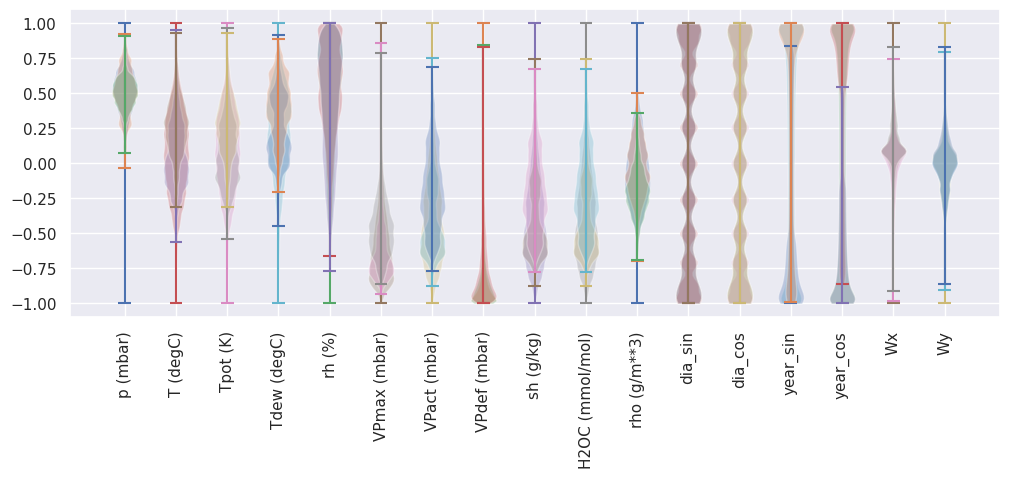

In [23]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(17):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(17)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

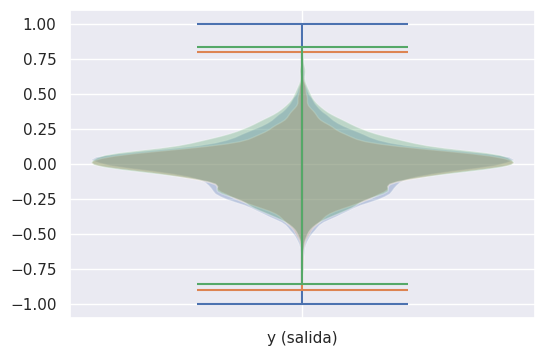

In [24]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

#8. Creación y entrenamiento del modelo

- Entradas: arreglos *x* (batches x input-length  x features = batches x 24 x 17)
- Salidas: arreglos *y* (batches x output-length x features = batches x 4 x 1)

Usaremos la raíz cuadrada del error cuadrático medio (o RMSE por sus siglas en Inglés: *root mean square error*) como pérdida para entrenar el modelo:

$RMSE = \sqrt{\frac{\sum_i (y_i-\hat{y_i})^2}{N}}$

donde:
- $y$: temperatura real
- $\hat{y}$: temperatura predicha
- $N$: cantidad de predicciones

In [25]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 17 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Y lo único que cambia con respecto al modelo multivariado + multi-step es
# el tamaño deldato de salida (4 horas)
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 55 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/55
157/157 - 9s - loss: 0.1537 - val_loss: 0.1409 - 9s/epoch - 55ms/step
Epoch 2/55
157/157 - 1s - loss: 0.1334 - val_loss: 0.1240 - 656ms/epoch - 4ms/step
Epoch 3/55
157/157 - 1s - loss: 0.1292 - val_loss: 0.1253 - 722ms/epoch - 5ms/step
Epoch 4/55
157/157 - 1s - loss: 0.1277 - val_loss: 0.1251 - 890ms/epoch - 6ms/step
Epoch 5/55
157/157 - 1s - loss: 0.1269 - val_loss: 0.1216 - 841ms/epoch - 5ms/step
Epoch 6/55
157/157 - 1s - loss: 0.1264 - val_loss: 0.1218 - 884ms/epoch - 6ms/step
Epoch 7/55
157/157 - 1s - loss: 0.1259 - val_loss: 0.1233 - 879ms/epoch - 6ms/step
Epoch 8/55
157/157 - 1s - loss: 0.1256 - val_loss: 0.1220 - 687ms/epoch - 4ms/step
Epoch 9/55
157/157 - 1s - loss: 0.1252 - val_loss: 0.1205 - 668ms/epoch - 4ms/step
Epoch 10/55
157/157 - 1s - loss: 0.1249 - val_loss: 0.1200 - 681ms/epoch - 4ms/step
Epoch 11/55
157/157 - 1s - loss: 0.1246 - val_loss: 0.1203 - 684ms/epoch - 4ms/step
Epoch 12/55
157/157 - 1s - loss: 0.1243 - val_loss: 0.1197 - 665ms/epoch - 4ms/step
Epo

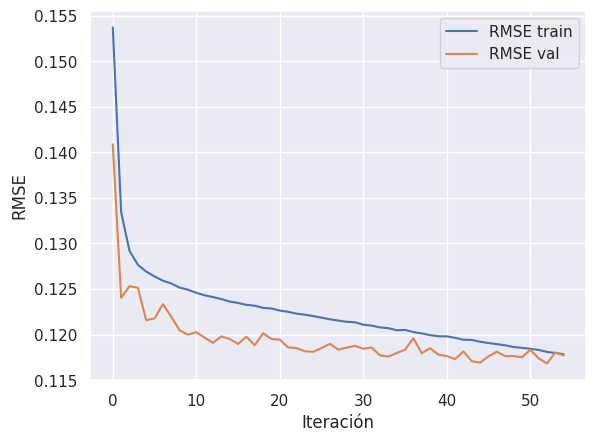

In [26]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

**Observaciones y sugerencias:**

- Al incluir las variables temporales obtenemos un RMSE ligeramente inferior al del tutorial anterior (0.118 vs. 0.120)
- En todo caso es importante tener en cuenta que se sugiere afinar los hiperparámetros de cada modelo para poder realizar comparaciones concluyentes.
- Al igual que en el caso del modelo multivariado-unistep en este caso, además de la afinación de hiperparámetros, se sugierer realizar un análisis de *feature importances* para determinar las covariables más relevantes en la predicción.

De nuevo, en la afinación se deberían considerar los siguientes hiperparámetros:
- *INPUT_LENGTH* y *OUTPUT_LENGTH* (esto implica modificar la fase de pre-procesamiento)
- Número de unidades de la Red LSTM
- Pérdida
- Tasa de aprendizaje
- Epochs
- Batch size

## 9. Desempeño del modelo

Suponiendo que el modelo ya ha sido afinado y entrenado, verificaremos su desempeño para el set de prueba y lo compararemos con el desempeño obtenido con los sets de entrenamiento y validación:

In [27]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.114
  RMSE val:	 0.114
  RMSE test:	 0.124


El desempeño para el set de prueba es comparable
(aunque ligeramente inferior) con los sets de entrenamiento y validación y por tanto podemos concluir que el modelo generaliza adecuadamente.

De nuevo, se debería afinar el modelo + realizar análisis de *feature importances* para intentar mejorar el desempeño.

Al igual que hicimos con el modelo univariado-multistep analicemos los errores (RMSEs) individuales para cada una de las horas predichas, para lo cual:

1. Generaremos las predicciones sobre la totalidad del set de prueba con el modelo entrenado.
2. Calcularemos y graficaremos el RMSE para cada instante de tiempo predicho

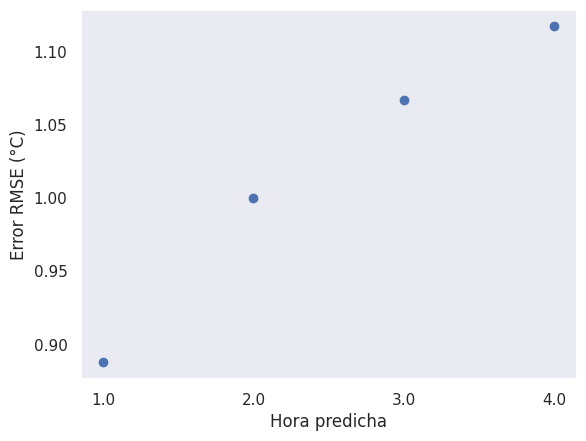

In [28]:
# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Realizar la transformación inversa de las predicciones para llevar sus
# valores a la escala original
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 3. Calcular RMSE para cada instante de tiempo predicho
diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) # BATCHESx4
proms = np.mean(diff_cuad, axis=0) # 1x4
rmse = np.sqrt(proms) # 1x4

# Graficar rmse para cada timestep
t = np.linspace(1,4,4)

fig, ax = plt.subplots()
ax.scatter(t,rmse)
ax.set_xlabel('Hora predicha')
ax.set_ylabel('Error RMSE (°C)')
plt.xticks(ticks=t, labels=t)
plt.grid();

Y al igual que ocurría con el modelo multivariado-multistep, vemos que en este caso el RMSE se incrementa a medida que nos movemos más hacia adelante en las predicciones.

De nuevo esto es un resultado preliminar y se sugiere afinar los hiperparámetros y realizar un análisis de *feature importances* para intentar mejorar este desempeño.

##10. Predicciones con el modelo entrenado

Suponiendo que el modelo ya ha sido afinado, podemos ponerlo a prueba con el set *test*.

Usaremos la misma función `predecir` usada en los videos anteriores:

In [29]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [30]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

Analicemos este desempeño gráficamente mostrando las temperaturas originales y las predichas por el modelo para cada uno de los datos en el set de prueba:

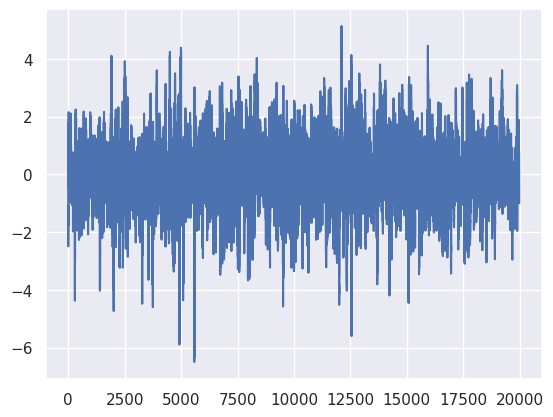

In [31]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred.flatten()
plt.plot(errores);

Se observa que:

- El promedio de errores es cercano a cero
- Pero en algunos instantes de tiempo se alcanzan errores extremos de hasta -6 y +5 grados.

Estos errores se podrían reducir al hacer una afinación del modelo o modificando el enfoque de predicción.

## 11. Análisis de la importancia de las características (*feature importances*)

El objetivo de este análisis es determinar cuáles de las características (o variables) introducidas a la entrada del modelo son más relevantes (tienen mayor importancia) al momento de generar las predicciones.

Y una de las técnicas más fáciles de implementar y más usadas en el caso de Redes LSTM es la que se conoce como **Permutación de la importancia de las características** (*permutation feature importance*; Fisher, Rudin y Dominici, 2018).

El algoritmo es el siguiente:

![](https://drive.google.com/uc?export=view&id=1Gtgp2QG-k7eg3onASqipOiryk0g_2T6O)

Y la lógica de funcionamiento de este algoritmo es sencilla:

1. Si al permutar una característica el error del modelo no cambia con respecto al valor de referencia (cociente cercano a 1) quiere decir que la característica no tiene mucha importancia al momento de generar las predicciones.
2. Pero si en cambio la permutación hace que el error sea mucho más grande (cociente mayor que 1) esto quiere decir que esa característica es importante y que al cambiarla el modelo empeorará sus predicciones.

Veamos cómo implementar el algoritmo:

In [32]:
def pfi_modelo(model, x, y, cols):
    '''Calcula la métrica "permutation feature importance"
    del modelo.

    Entradas:
    - model: modelo entrenado
    - x: arreglo de entradas (características)
    - y: arreglo de targets (salidas de referencia)
    - cols: nombres de las columnas en el set de datos original

    Retorna:
    - DataFrame con los features importances

    '''
    NFEATS = x.shape[2] # Número de columnas del arreglo de entradas (17)

    # Arreglo que contendrá los PFIs calculados
    resultados = []

    # 1. Estimar el error original del modelo entrenado
    rmse_orig = model.evaluate(x, y, verbose = 0)

    # 2. Iterar sobre cada columna y para cada iteración:
    # 2.1. Permutar la columna
    # 2.2. Calcular rmse_perm
    # 2.3. Calcular pfi = rmse_perm/rmse_orig
    # 2.4. Almacenar el resultado
    for k in range(NFEATS):
        print(f'\tCalculando feature_importance variable {k+1}/{NFEATS}')

        # Permutar covariable k
        save_col = x[:,:,k].copy() # Extraer una copia de la columna
        np.random.shuffle(x[:,:,k]) # Permutarla aleatoriamente

        # Calcular rmse_perm
        rmse_perm = model.evaluate(x, y, verbose=0)

        # Calcular cociente (pfi)
        pfi = rmse_perm/rmse_orig

        # Almacenar en "resultados"
        resultados.append({'feature':cols[k],'feature_importance':pfi})

        # Y restablecer la covariable a su posicion original (necesario
        # para la siguiente iteración)
        x[:,:,k] = save_col

    # Crear DataFrame de Pandas a partir de "resultados"
    pfis = pd.DataFrame(resultados).sort_values(by='feature_importance', ascending=False)

    return pfis

Ahora sólo nos queda llamar la función anterior usando el set de validación:

In [34]:
feat_imp = pfi_modelo(modelo,
                      x_vl_s,
                      y_vl_s,
                      df.columns)
feat_imp

	Calculando feature_importance variable 1/17
	Calculando feature_importance variable 2/17
	Calculando feature_importance variable 3/17
	Calculando feature_importance variable 4/17
	Calculando feature_importance variable 5/17
	Calculando feature_importance variable 6/17
	Calculando feature_importance variable 7/17
	Calculando feature_importance variable 8/17
	Calculando feature_importance variable 9/17
	Calculando feature_importance variable 10/17
	Calculando feature_importance variable 11/17
	Calculando feature_importance variable 12/17
	Calculando feature_importance variable 13/17
	Calculando feature_importance variable 14/17
	Calculando feature_importance variable 15/17
	Calculando feature_importance variable 16/17
	Calculando feature_importance variable 17/17


,feature,feature_importance
16,Wy,1.712674
11,dia_sin,1.067722
12,dia_cos,1.066358
15,Wx,1.065819
14,year_cos,1.050237
4,rh (%),1.033823
10,rho (g/m**3),1.023137
0,p (mbar),1.019291
9,H2OC (mmol/mol),1.016079
5,VPmax (mbar),1.014389


E incluso resulta más sencillo interpretar este resultado gráficamente:

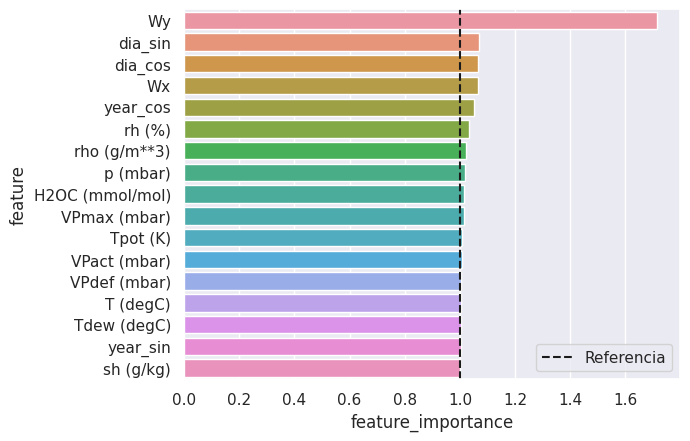

In [35]:
ax = sns.barplot(data=feat_imp, x='feature_importance', y='feature')
ax.axvline(1.0, color='k', linestyle='--', label='Referencia')
ax.legend();

Y para el modelo que construimos, con las variables de entrada usadas y el tipo de predicción que estamos realizando (multi-step) vemos que las top-5 variables más relevantes son:

- Componente "y" de la velocidad del viento
- El día (componente senoidal)
- El año (componente cosenoidal)
- Componente "x" de la velocidad del viento
- El día (componente cosenoidal)


Esto nos permite no sólo determinar cuáles son las variables más relevantes sino incluso entrenar un nuevo modelo únicamente con las variables que tengan mayor impacto en la predicción (por ejemplo las top-5 o las top-10).

## 12. Conclusiones y sugerencias

El método que acabamos de ver es muy fácil de implementar y nos arroja un análisis de importancia de características que es muy fácil de interpretar.

Además vemos que el uso de las variables temporales (tutorial anterior) es de gran relevancia al momento de las predicciones.